This notebook is designed to <b>analyze and visualize the results of adversarial attacks</b> on various question-answering models.<br /><br />

Key features of this analysis notebook:
<ol>
    <li>Comprehensive evaluation of multiple models (BERT, RoBERTa, ELECTRA) and their fine-tuned versions.</li>
    <li>Analysis of various attack types and their effectiveness.</li>
    <li>Comparison of model performance before and after fine-tuning.</li>
    <li>Visualization of key metrics (F1 Score, Exact Match, BLEU Score, grammatical errors).</li>
    <li>Detailed analysis of the CEIA method, including performance comparisons and example analysis.</li>
</ol>

The script provides a thorough analysis of how different question-answering models perform under various adversarial attacks. It helps in understanding:
<ul>
    <li>Which models are more robust against specific types of attacks.</li>
    <li>The impact of fine-tuning on model robustness.</li>
    <li>The effectiveness of different attack strategies.</li>
    <li>How factors like answer length affect attack success.</li>
    <li>The specific performance and characteristics of the CEIA method compared to other attacks.</li>
</ul>

This analysis framework is valuable for researchers and practitioners in the fields of natural language processing and adversarial machine learning, offering insights into model vulnerabilities and the effectiveness of different attack strategies.

### Loading libraries
Imports necessary libraries for data manipulation, visualization, natural language processing, and machine learning.

In [1]:
import json
import os
import numpy as np 
import matplotlib.pyplot as plt
import nltk
import pandas as pd
from IPython.display import Image, display
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from transformers import (AutoModelForQuestionAnswering, AutoTokenizer, BertForQuestionAnswering, BertTokenizer)
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ferhatsarikaya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Create images folder if it doesn't exist
if not os.path.exists("images"):
    os.makedirs("images")

### AdversarialAttackAnalyzer class
Initializes with summary and result files for different models.<br />
Loads data from CSV files into pandas DataFrames.<br />
Includes methods for various analyses and visualizations.<br />

In [4]:
class AdversarialAttackAnalyzer:
    def __init__(self, summary_files, result_files):
        self.summary_files = summary_files
        self.result_files = result_files
        self.summary_data = {}
        self.result_data = {}
        self.load_data()
        # Initialize SentenceTransformer for Context Preservation Analysis
        self.sentence_model = SentenceTransformer('bert-base-nli-mean-tokens') 

    def load_data(self):
        """Loads summary and result data from CSV files."""
        for model_type, file_path in self.summary_files.items():
            self.summary_data[model_type] = pd.read_csv(file_path)
        for model_type, file_path in self.result_files.items():
            self.result_data[model_type] = pd.read_csv(file_path)

    def plot_summary_metric(self, metric, title, ylabel):
        """Plots a bar chart for a given metric across different models and attacks."""
        fig, ax = plt.subplots(figsize=(12, 6))

        num_models = len(self.summary_data)
        bar_width = 0.8 / num_models 
        index = np.arange(len(self.summary_data[list(self.summary_data.keys())[0]]['attack']))

        for i, model_type in enumerate(self.summary_data):
            data = self.summary_data[model_type]
            ax.bar(index + i * bar_width, data[metric], label=model_type, width=bar_width)

        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.legend(title='Model')
        ax.set_xticks(index + bar_width / 2) 
        ax.set_xticklabels(data['attack'], rotation=45, ha='right')
        plt.tight_layout()
        image_name = f"images/Analysis_{metric.replace(' ', '')}.png"
        plt.savefig(image_name)
        plt.close(fig)
        display(Image(filename=image_name))

    def analyze_grammatical_errors(self):
        """Analyzes and visualizes grammatical errors across different attacks and models."""
        self.plot_summary_metric('Avg Grammatical Errors', 'Average Grammatical Errors per Attack', 'Average Errors')

    def analyze_performance_metrics(self):
        """Analyzes and visualizes F1 Score, Exact Match, and BLEU Score."""
        self.plot_summary_metric('F1 Score', 'F1 Score per Attack', 'F1 Score')
        self.plot_summary_metric('Exact Match', 'Exact Match Rate per Attack', 'Exact Match Rate')
        self.plot_summary_metric('BLEU Score', 'BLEU Score per Attack', 'BLEU Score')

    def analyze_model_robustness(self):
        """Compares the robustness of different models based on F1 score."""
        for attack in self.summary_data['BERT-base']['attack']:
            print(f"## Model Robustness Comparison for {attack} Attack:")
            for metric in ['F1 Score', 'Exact Match', 'BLEU Score']:
                print(f"- **{metric}:**")
                for model_type in self.summary_data:
                    f1 = self.summary_data[model_type][self.summary_data[model_type]['attack'] == attack][metric].values[0]
                    print(f"    - {model_type}: {f1:.4f}")
            print("-" * 50)

    def analyze_attack_effectiveness(self):
        """Analyzes which attacks are most effective based on the lowest exact match rate."""
        for model_type in self.summary_data:
            print(f"## Attack Effectiveness for {model_type}:")
            for attack in self.summary_data[model_type]['attack']:
                exact_match = self.summary_data[model_type][self.summary_data[model_type]['attack'] == attack]['Exact Match'].values[0]
                print(f"- {attack}: {1 - exact_match:.2%} unsuccessful (lower is more effective)")
            print("-" * 50)

    def analyze_fine_tuning_impact(self):
        """Analyzes the impact of fine-tuning on model robustness."""
        for base_model in ['BERT', 'RoBERTa', 'ELECTRA']:
            print(f"## Fine-tuning Impact for {base_model}:")
            base_model_data = self.summary_data[f'{base_model}-base']
            finetuned_model_data = self.summary_data[f'{base_model}-finetuned']

            for attack in base_model_data['attack']:
                base_f1 = base_model_data[base_model_data['attack'] == attack]['F1 Score'].values[0]
                finetuned_f1 = finetuned_model_data[finetuned_model_data['attack'] == attack]['F1 Score'].values[0]
                difference = finetuned_f1 - base_f1
                print(f"- {attack}: Fine-tuned F1 is {'higher' if difference > 0 else 'lower'} by {abs(difference):.4f}")
            print("-" * 50)

    def calculate_sentence_similarity(self, sentence1, sentence2):
        """Calculates cosine similarity between sentence embeddings."""
        embeddings = self.sentence_model.encode([sentence1, sentence2])
        similarity = cosine_similarity(embeddings[0].reshape(1, -1), embeddings[1].reshape(1, -1))[0][0]
        return similarity
    
    def analyze_model_architecture_comparison(self):
        """Compares the performance of different model architectures."""
        for attack in self.summary_data['BERT-base']['attack']:
            print(f"## Model Architecture Comparison for {attack} Attack (F1 Score):")
            for model_arch in ['BERT', 'RoBERTa', 'ELECTRA']:
                for model_type in [f'{model_arch}-base', f'{model_arch}-finetuned']:
                    f1 = self.summary_data[model_type][self.summary_data[model_type]['attack'] == attack]['F1 Score'].values[0]
                    print(f"   - {model_type}: {f1:.4f}")
            print("-" * 50)

    def analyze_attack_success_rate(self):
        """Calculates the success rate of each attack type for each model."""
        for model_type in self.result_data:
            print(f"## Attack Success Rate for {model_type}:")
            for attack_type in self.result_data[model_type]['attack'].unique():
                total_attacks = len(self.result_data[model_type][self.result_data[model_type]['attack'] == attack_type])
                successful_attacks = len(self.result_data[model_type][(self.result_data[model_type]['attack'] == attack_type) & (self.result_data[model_type]['exact_match'] == False)])
                success_rate = successful_attacks / total_attacks if total_attacks > 0 else 0
                print(f"- {attack_type}: {success_rate * 100:.2f}%")
            print("-" * 50)

    def visualize_attack_success_rate(self):
        """Visualizes the success rate of each attack type for each model."""
        attack_types = self.result_data[list(self.result_data.keys())[0]]['attack'].unique()
        models = list(self.result_data.keys())

        success_rates = {model: {} for model in models}

        for model in models:
            for attack_type in attack_types:
                total_attacks = len(self.result_data[model][self.result_data[model]['attack'] == attack_type])
                successful_attacks = len(self.result_data[model][(self.result_data[model]['attack'] == attack_type) & (self.result_data[model]['exact_match'] == False)])
                success_rate = successful_attacks / total_attacks if total_attacks > 0 else 0
                success_rates[model][attack_type] = success_rate * 100

        fig, ax = plt.subplots(figsize=(15, 8))
        bar_width = 0.13
        index = np.arange(len(attack_types))

        for i, model in enumerate(models):
            rates = [success_rates[model][attack] for attack in attack_types]
            ax.bar(index + i * bar_width, rates, bar_width, label=model)

        ax.set_ylabel('Success Rate (%)')
        ax.set_title('Attack Success Rate Comparison')
        ax.set_xticks(index + bar_width * (len(models) - 1) / 2)
        ax.set_xticklabels(attack_types, rotation=45, ha='right')
        ax.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        plt.savefig('images/Attack_Success_Rate_Comparison.png', bbox_inches='tight')
        plt.close(fig)
        display(Image(filename='images/Attack_Success_Rate_Comparison.png'))
            
    def analyze_answer_length_impact(self):
        """Analyzes the impact of answer length on attack success."""
        for model_type in self.result_data:
            print(f"## Answer Length Impact Analysis for {model_type}:")
            data = self.result_data[model_type].copy()
            data['answer_length'] = data['ground_truth'].str.split().str.len()
            
            for attack_type in data['attack'].unique():
                attack_data = data[data['attack'] == attack_type]
                successful_attacks = attack_data[attack_data['exact_match'] == False]
                
                if len(successful_attacks) > 0:
                    avg_answer_length = successful_attacks['answer_length'].mean()
                    print(f"- {attack_type}: Average answer length for successful attacks: {avg_answer_length:.2f}")
                else:
                    print(f"- {attack_type}: No successful attacks found to analyze answer length.")

            print("-" * 50)

    def analyze_ceia_specific(self):
        print("## CEIA-Specific Analysis:")

        ceia_data = {model: df[df['attack'] == 'CEIA'] for model, df in self.result_data.items()}

        # 1. Performance Analysis
        print("### Performance Analysis:")
        for model, data in ceia_data.items():
            avg_f1 = data['f1_score'].mean()
            avg_em = data['exact_match'].mean()
            avg_bleu = data['bleu_score'].mean()
            print(f"- {model}:")
            print(f"  Average F1 Score: {avg_f1:.4f}")
            print(f"  Average Exact Match: {avg_em:.4f}")
            print(f"  Average BLEU Score: {avg_bleu:.4f}")

        # 2. Grammatical Error Analysis
        print("\n### Grammatical Error Analysis:")
        for model, data in ceia_data.items():
            avg_errors = data['grammatical_errors'].mean()
            print(f"- {model}: Average grammatical errors: {avg_errors:.4f}")

        # 3. Attack Success Rate Comparison
        print("\n### Attack Success Rate Comparison:")
        for model, data in self.result_data.items():
            ceia_success = (data[data['attack'] == 'CEIA']['exact_match'] == False).mean()
            other_success = (data[data['attack'] != 'CEIA']['exact_match'] == False).mean()
            print(f"- {model}:")
            print(f"  CEIA success rate: {ceia_success:.4f}")
            print(f"  Other attacks average success rate: {other_success:.4f}")

        # 4. Visualization of CEIA vs Other Attacks
        success_rates = {
            model: {
                'CEIA': (data[data['attack'] == 'CEIA']['exact_match'] == False).mean(),
                'Others': (data[data['attack'] != 'CEIA']['exact_match'] == False).mean()
            } for model, data in self.result_data.items()
        }

        fig, ax = plt.subplots(figsize=(12, 6))
        x = np.arange(len(success_rates))
        width = 0.35

        ceia_rates = [rates['CEIA'] for rates in success_rates.values()]
        other_rates = [rates['Others'] for rates in success_rates.values()]

        ax.bar(x - width/2, ceia_rates, width, label='CEIA')
        ax.bar(x + width/2, other_rates, width, label='Other Attacks')

        ax.set_ylabel('Success Rate')
        ax.set_title('CEIA vs Other Attacks Success Rate')
        ax.set_xticks(x)
        ax.set_xticklabels(success_rates.keys(), rotation=45, ha='right')
        ax.legend()

        plt.tight_layout()
        plt.savefig('images/Analysis_CEIA_Comparison.png')
        plt.close(fig)
        display(Image(filename='images/Analysis_CEIA_Comparison.png'))

        print("\nCEIA-Specific Analysis completed. Visualization saved as 'Analysis_CEIA_Comparison.png'.")

        # 5. Example Analysis
        print("\n### CEIA Attack Example:")
        for model, data in ceia_data.items():
            if not data.empty:
                example = data.iloc[0]
                print(f"Model: {model}")
                print(f"Question: {example['question']}")
                print(f"Context: {example['context']}")
                print(f"Ground Truth: {example['ground_truth']}")
                print(f"Predicted Answer: {example['predicted_answer']}")
                print(f"F1 Score: {example['f1_score']:.4f}")
                print(f"Exact Match: {example['exact_match']}")
                print(f"BLEU Score: {example['bleu_score']:.4f}")
                print(f"Grammatical Errors: {example['grammatical_errors']}")
                break  # Just show one example

### Data loading and preprocessing
Loads summary and result data from CSV files for different models and attack types.
Uses SentenceTransformer for semantic similarity analysis.

In [5]:
summary_files = {
    'BERT-base': 'Results/Summary/bert-base-uncased_adversarial_attack_summary.csv',
    'BERT-finetuned': 'Results/Summary/bert-base-uncased-finetuned-squad2_adversarial_attack_summary.csv',
    'RoBERTa-base': 'Results/Summary/roberta_adversarial_attack_summary.csv',
    'RoBERTa-finetuned': 'Results/Summary/roberta-base-squad2_adversarial_attack_summary.csv',
    'ELECTRA-base': 'Results/Summary/electra_adversarial_attack_summary.csv',
    'ELECTRA-finetuned': 'Results/Summary/electra-base-squad2_adversarial_attack_summary.csv'
}

result_files = {
    'BERT-base': 'Results/Attack/bert-base-uncased_adversarial_attack_results.csv',
    'BERT-finetuned': 'Results/Attack/bert-base-uncased-squad2_adversarial_attack_results.csv',
    'RoBERTa-base': 'Results/Attack/roberta_adversarial_attack_results.csv',
    'RoBERTa-finetuned': 'Results/Attack/roberta-base-squad2_adversarial_attack_results.csv',
    'ELECTRA-base': 'Results/Attack/electra_adversarial_attack_results.csv',
    'ELECTRA-finetuned': 'Results/Attack/electra-base-squad2_adversarial_attack_results.csv'
}


# Initialize the analyzer
analyzer = AdversarialAttackAnalyzer(summary_files, result_files)

/Users/ferhatsarikaya/miniforge3/envs/new_tf_env/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Analysis methods

<b>plot_summary_metric:</b> Generates bar charts for various metrics across different models and attacks.<br />
<b>analyze_grammatical_errors:</b> Visualizes average grammatical errors for each attack and model.<br />
<b>analyze_performance_metrics:</b> Visualizes F1 Score, Exact Match, and BLEU Score for each attack and model.

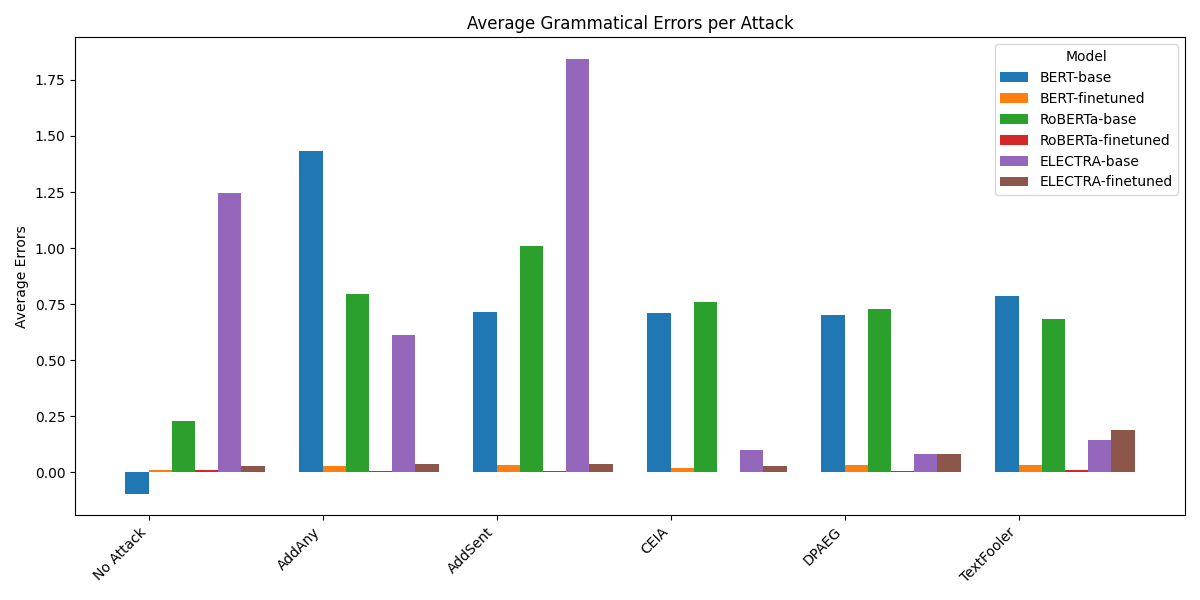

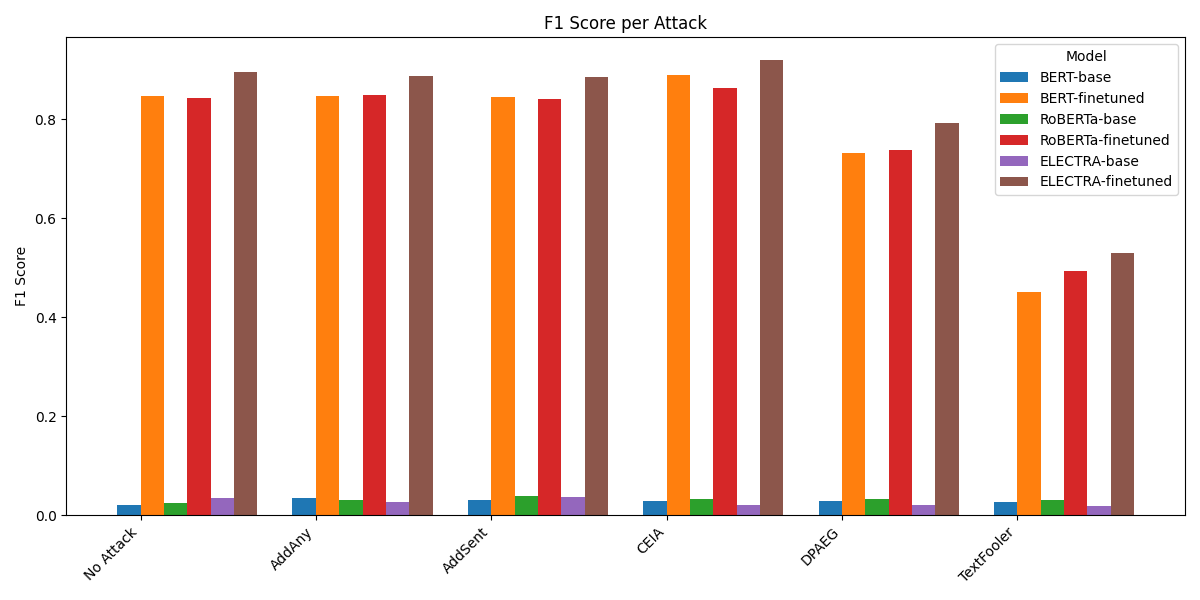

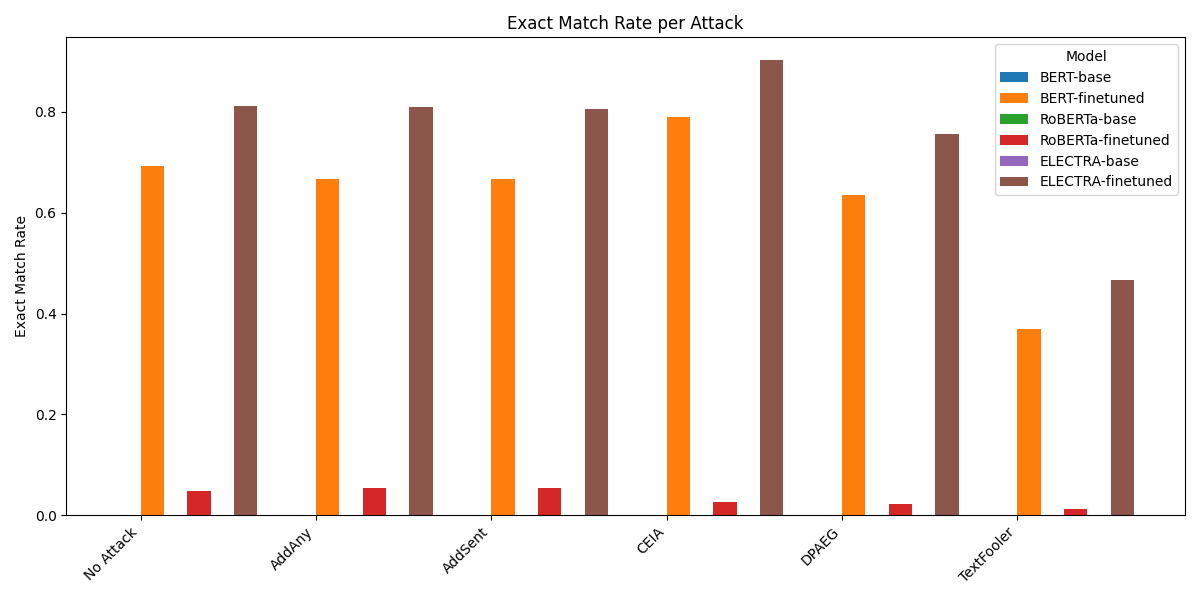

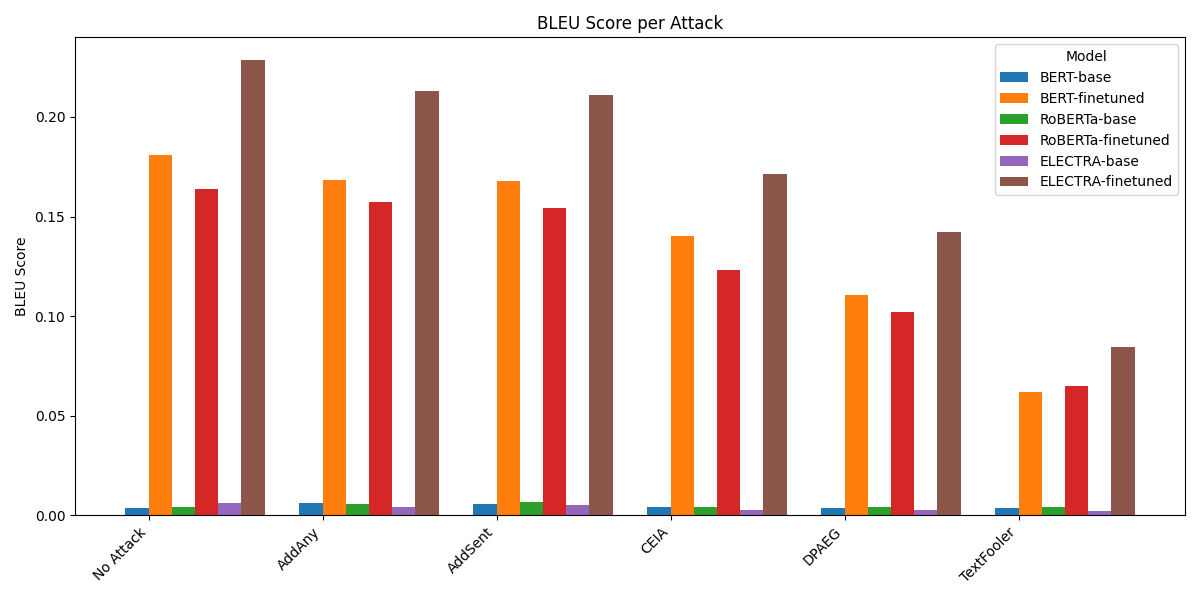

In [6]:
# Perform analysis
analyzer.analyze_grammatical_errors()
analyzer.analyze_performance_metrics()

<ol>
    <li>
        <b>Attack Types:</b>
        The study examines five types of adversarial attacks: AddAny, AddSent, CEIA, DPAEG, and TextFooler. These attacks aim to manipulate input text to mislead the target models.
    </li>
    <br />
    <li>
        <b>Models Evaluated:</b>
        Three model architectures are tested: BERT, RoBERTa, and ELECTRA. For each architecture, both base and fine-tuned versions are evaluated, resulting in six model variants.
    </li>
    <br />
    <li>
        <b>Evaluation Metrics:</b>
        The analysis uses four key metrics:
        <ul>
            <li>Average Grammatical Errors</li>
            <li>BLEU Score</li>
            <li>Exact Match Rate</li>
            <li>F1 Score</li>
        </ul>
    </li>
    <br />
    <li>
        <b>Grammatical Error Analysis (Image 1):</b>
        <ul>
            <li>ELECTRA-base shows the highest grammatical error rate for AddSent attacks.</li>
            <li>Fine-tuned models generally exhibit fewer grammatical errors compared to their base counterparts.</li>
            <li>CEIA and DPAEG attacks tend to produce fewer grammatical errors across all models.</li>
        </ul>
    </li>
    <br />
    <li>
        <b>F1 Score Analysis (Image 2):</b>
        <ul>
            <li>ELECTRA-finetuned maintains the highest F1 scores across all attacks.</li>
            <li>TextFooler attack causes the most significant drop in F1 scores for all models.</li>
            <li>Fine-tuned models consistently outperform their base counterparts in terms of F1 scores.</li>
        </ul>
    </li>
    <br />
    <li>
        <b>Exact Match Rate Analysis (Image 3):</b>
        <ul>
            <li>ELECTRA-finetuned demonstrates the highest exact match rates for most attacks.</li>
            <li>RoBERTa-finetuned shows surprisingly low exact match rates across all attacks.</li>
            <li>DPAEG attack appears to be the most effective in reducing exact match rates for most models.</li>
        </ul>
    </li>
    <br />
    <li>
        <b>BLEU Score Analysis (Image 4):</b>
        <ul>
            <li>ELECTRA-finetuned consistently achieves the highest BLEU scores across all attacks.</li>
            <li>Base models have significantly lower BLEU scores compared to fine-tuned versions.</li>
            <li>TextFooler attack results in the lowest BLEU scores for all models, indicating more substantial text alterations.</li>
        </ul>
    </li>
    <br />
    <li>
        <b>Attack Effectiveness:</b>
        <ul>
            <li>TextFooler appears to be the most effective attack, causing the largest decreases in BLEU, Exact Match, and F1 scores.</li>
            <li>CEIA and DPAEG show moderate effectiveness, balancing between maintaining grammatical correctness and reducing model performance.</li>
            <li>AddAny and AddSent attacks seem less effective compared to the other methods.</li>
        </ul>
    </li>
    <br />
    <li>
        <b>Model Robustness:</b>
        <ul>
            <li>ELECTRA-finetuned demonstrates the highest overall robustness against the tested attacks.</li>
            <li>Base models are generally more vulnerable to attacks compared to their fine-tuned versions.</li>
            <li>RoBERTa-finetuned shows unexpectedly low robustness in terms of exact match rate.</li>
        </ul>
    </li>
    <br />
    <li>
        <b>Fine-tuning Impact:</b>
        <ul>
            <li>Fine-tuning significantly improves model performance and robustness across all architectures.</li>
            <li>The improvement is most pronounced in BLEU scores and F1 scores.</li>
        </ul>
    </li>
</ol>


### analyze_model_robustness
Compares model performance across different attacks.

In [7]:
analyzer.analyze_model_robustness()

## Model Robustness Comparison for No Attack Attack:
- **F1 Score:**
    - BERT-base: 0.0206
    - BERT-finetuned: 0.8475
    - RoBERTa-base: 0.0242
    - RoBERTa-finetuned: 0.8434
    - ELECTRA-base: 0.0349
    - ELECTRA-finetuned: 0.8948
- **Exact Match:**
    - BERT-base: 0.0001
    - BERT-finetuned: 0.6918
    - RoBERTa-base: 0.0000
    - RoBERTa-finetuned: 0.0490
    - ELECTRA-base: 0.0000
    - ELECTRA-finetuned: 0.8121
- **BLEU Score:**
    - BERT-base: 0.0036
    - BERT-finetuned: 0.1807
    - RoBERTa-base: 0.0040
    - RoBERTa-finetuned: 0.1640
    - ELECTRA-base: 0.0063
    - ELECTRA-finetuned: 0.2285
--------------------------------------------------
## Model Robustness Comparison for AddAny Attack:
- **F1 Score:**
    - BERT-base: 0.0342
    - BERT-finetuned: 0.8458
    - RoBERTa-base: 0.0316
    - RoBERTa-finetuned: 0.8492
    - ELECTRA-base: 0.0274
    - ELECTRA-finetuned: 0.8877
- **Exact Match:**
    - BERT-base: 0.0000
    - BERT-finetuned: 0.6669
    - RoBERTa-base: 0

<ol>
    <li>
        <b>General Observations:</b>
        <ul>
            <li>Fine-tuned models consistently outperform their base counterparts across all metrics and attacks.</li>
            <li>ELECTRA-finetuned shows the highest robustness among all models for most attacks.</li>
            <li>Base models perform poorly across all attacks, with F1 scores, Exact Match rates, and BLEU scores close to zero.</li>
        </ul>
    </li>
    <br />
    <li>
        <b>Attack Effectiveness (from least to most effective):</b>
        <ul>
            <li>CEIA appears to be the least effective attack, with models maintaining the highest scores.</li>
            <li>AddAny and AddSent show similar effectiveness, slightly more than CEIA.</li>
            <li>DPAEG is more effective than the previous three.</li>
            <li>TextFooler is the most effective attack, causing the largest drops in performance across all models.</li>
        </ul>
    </li>
    <br />
    <li>
        <b>Model-specific Analysis:</b>
        <ul>
            <li>
                <b>BERT:</b>
                <ul>
                    <li>Fine-tuning significantly improves robustness.</li>
                    <li>Performs well against CEIA, but vulnerable to TextFooler.</li>
                </ul>
            </li>
            <li>
                <b>RoBERTa:</b>
                <ul>
                    <li>Fine-tuned version shows good F1 scores but unexpectedly low Exact Match rates.</li>
                    <li>Slightly more robust than BERT-finetuned in F1 scores for some attacks.</li>
                </ul>
            </li>
            <li>
                <b>ELECTRA:</b>
                <ul>
                    <li>Fine-tuned version consistently outperforms other models across all metrics and attacks.</li>
                    <li>Shows the highest robustness, especially in Exact Match and BLEU scores.</li>
                </ul>
            </li>
        </ul>
    </li>
    <br />
    <li>
        <b>Metric-specific Insights:</b>
        <ul>
            <li>
                <b>F1 Score:</b>
                <ul>
                    <li>Fine-tuned models maintain F1 scores above $0.8$ for less effective attacks.</li>
                    <li>TextFooler causes the most significant drop, with scores around $0.45$ - $0.53$ for fine-tuned models.</li>
                </ul>
            </li>
            <li>
                <b>Exact Match:</b>
                <ul>
                    <li>ELECTRA-finetuned maintains the highest Exact Match rates ($0.46$ - $0.90$) across all attacks.</li>
                    <li>RoBERTa-finetuned shows unexpectedly low Exact Match rates ($0.01$ - $0.05$) despite good F1 scores.</li>
                </ul>
            </li>
            <li>
                <b>BLEU Score:</b>
                <ul>
                    <li>Consistently lower than F1 and Exact Match scores, indicating significant changes in text structure.</li>
                    <li>ELECTRA-finetuned maintains the highest BLEU scores across all attacks.</li>
                </ul>
            </li>
        </ul>
    </li>
    <br />
    <li>
        <b>Robustness Ranking (from most to least robust):</b>
        <ol>
            <li>ELECTRA-finetuned</li>
            <li>BERT-finetuned</li>
            <li>RoBERTa-finetuned</li>
            <li>BERT-base</li>
            <li>RoBERTa-base</li>
            <li>ELECTRA-base</li>
        </ol>
    </li>
    <br />
    <li>
        <b>Attack Resistance:</b>
        <ul>
            <li>TextFooler proves to be the most challenging attack for all models.</li>
        </ul>
    </li>
</ol>

In conclusion, fine-tuning significantly improves model robustness against adversarial attacks. ELECTRA-finetuned demonstrates the highest overall robustness, while base models are highly vulnerable to all types of attacks. The effectiveness of attacks varies, with TextFooler being the most potent. These findings highlight the importance of fine-tuning and the need for continued research in developing more robust models against diverse adversarial attacks.

### analyze_attack_effectiveness
Evaluates which attacks are most effective based on exact match rates.

In [8]:
analyzer.analyze_attack_effectiveness()

## Attack Effectiveness for BERT-base:
- No Attack: 99.99% unsuccessful (lower is more effective)
- AddAny: 100.00% unsuccessful (lower is more effective)
- AddSent: 100.00% unsuccessful (lower is more effective)
- CEIA: 99.99% unsuccessful (lower is more effective)
- DPAEG: 99.99% unsuccessful (lower is more effective)
- TextFooler: 100.00% unsuccessful (lower is more effective)
--------------------------------------------------
## Attack Effectiveness for BERT-finetuned:
- No Attack: 30.82% unsuccessful (lower is more effective)
- AddAny: 33.31% unsuccessful (lower is more effective)
- AddSent: 33.29% unsuccessful (lower is more effective)
- CEIA: 21.07% unsuccessful (lower is more effective)
- DPAEG: 36.50% unsuccessful (lower is more effective)
- TextFooler: 63.01% unsuccessful (lower is more effective)
--------------------------------------------------
## Attack Effectiveness for RoBERTa-base:
- No Attack: 100.00% unsuccessful (lower is more effective)
- AddAny: 100.00% unsuccessf

<ol>
    <li>
        <b>Base Models:</b>
        <ul>
            <li>BERT-base, RoBERTa-base, and ELECTRA-base all show nearly $100$% unsuccessful rates across all attack types.</li>
            <li>This indicates that base models are extremely vulnerable to all types of adversarial attacks tested.</li>
            <li>The attacks are highly effective against these models, suggesting very low robustness in their base forms.</li>
        </ul>
    </li>
    <br />
    <li>
        <b>Fine-tuned Models:</b>
        <ol>
            <li>
                <b>BERT-finetuned:</b>
                <ul>
                    <li>Shows significant improvement in robustness compared to its base version.</li>
                    <li>Most vulnerable to TextFooler ($63.01$% unsuccessful) and most robust against CEIA ($21.07$% unsuccessful).</li>
                    <li>AddAny and AddSent have similar effectiveness (around $33$% unsuccessful).</li>
                </ul>
            </li>
            <li>
                <b>RoBERTa-finetuned:</b>
                <ul>
                    <li>Shows the least improvement in robustness among fine-tuned models.</li>
                    <li>Most vulnerable to TextFooler ($98.66$% unsuccessful) and most robust against AddAny/AddSent (around $94.6$% unsuccessful).</li>
                    <li>Consistently high vulnerability across all attacks.</li>
                </ul>
            </li>
            <li>
                <b>ELECTRA-finetuned:</b>
                <ul>
                    <li>Shows the largest improvement in robustness among fine-tuned models.</li>
                    <li>Most vulnerable to TextFooler ($53.40$% unsuccessful) and most robust against CEIA ($9.78$% unsuccessful).</li>
                    <li>AddAny and AddSent have similar effectiveness (around $19$% unsuccessful).</li>
                </ul>
            </li>
        </ol>
    </li>
    <br />
    <li>
        <b>Attack Effectiveness Ranking (from most to least effective):</b>
        <ul>
            <li>
                <b>For BERT-finetuned and ELECTRA-finetuned:</b>
                <ol>
                    <li>TextFooler</li>
                    <li>DPAEG</li>
                    <li>AddAny / AddSent</li>
                    <li>CEIA</li>
                </ol>
            </li>
            <li>
                <b>For RoBERTa-finetuned:</b>
                <ol>
                    <li>TextFooler</li>
                    <li>DPAEG</li>
                    <li>CEIA</li>
                    <li>AddAny / AddSent</li>
                </ol>
            </li>
        </ul>
    </li>
    <br />
    <li>
        <b>Model Robustness Ranking (from most to least robust):</b>
        <ul>
            <li>ELECTRA-finetuned</li>
            <li>BERT-finetuned</li>
            <li>RoBERTa-finetuned</li>
            <li>BERT-base / RoBERTa-base / ELECTRA-base (all equally vulnerable)</li>
        </ul>
    </li>
    <br />
    <li>
        <b>Key Observations:</b>
        <ul>
            <li>Base models are extremely vulnerable to all types of adversarial attacks.</li>
            <li>Fine-tuning significantly improves model robustness against adversarial attacks.</li>
            <li>TextFooler is consistently the most effective attack against all models.</li>
            <li>CEIA is generally the least effective attack, except for RoBERTa-finetuned.</li>
            <li>RoBERTa-finetuned shows the least improvement after fine-tuning, remaining highly vulnerable.</li>
            <li>ELECTRA-finetuned shows the largest improvement in robustness after fine-tuning.</li>
        </ul>
    </li>
    <br />
    <li>
        <b>Implications:</b>
        <ul>
            <li>The effectiveness of attacks varies across different model architectures and their fine-tuned versions.</li>
            <li>Fine-tuning is crucial for improving model robustness against adversarial attacks.</li>
            <li>Different attack strategies have varying levels of success depending on the model architecture and whether it's fine-tuned.</li>
            <li>The significant improvement in robustness for ELECTRA after fine-tuning warrants further investigation into why this occurs and how it might be leveraged in other models.</li>
            <li>The persistent vulnerability of RoBERTa-finetuned suggests a need for alternative fine-tuning strategies or architectural modifications to improve its robustness.</li>
        </ul>
    </li>
</ol>

### analyze_fine_tuning_impact
Assesses the impact of fine-tuning on model robustness.

In [9]:
analyzer.analyze_fine_tuning_impact()

## Fine-tuning Impact for BERT:
- No Attack: Fine-tuned F1 is higher by 0.8270
- AddAny: Fine-tuned F1 is higher by 0.8116
- AddSent: Fine-tuned F1 is higher by 0.8118
- CEIA: Fine-tuned F1 is higher by 0.8599
- DPAEG: Fine-tuned F1 is higher by 0.7046
- TextFooler: Fine-tuned F1 is higher by 0.4234
--------------------------------------------------
## Fine-tuning Impact for RoBERTa:
- No Attack: Fine-tuned F1 is higher by 0.8192
- AddAny: Fine-tuned F1 is higher by 0.8176
- AddSent: Fine-tuned F1 is higher by 0.8023
- CEIA: Fine-tuned F1 is higher by 0.8286
- DPAEG: Fine-tuned F1 is higher by 0.7052
- TextFooler: Fine-tuned F1 is higher by 0.4615
--------------------------------------------------
## Fine-tuning Impact for ELECTRA:
- No Attack: Fine-tuned F1 is higher by 0.8598
- AddAny: Fine-tuned F1 is higher by 0.8603
- AddSent: Fine-tuned F1 is higher by 0.8470
- CEIA: Fine-tuned F1 is higher by 0.8981
- DPAEG: Fine-tuned F1 is higher by 0.7714
- TextFooler: Fine-tuned F1 is higher

<ol>
    <li>
        <b>General Observations:</b>
        <ul>
            <li>Across all models and attack types, fine-tuning consistently improves the F1 score.</li>
            <li>The improvement varies depending on the model and attack type.</li>
        </ul>
    </li>
    <br />
    <li>
        <b>Model-specific Analysis:</b>
        <ol>
            <li>
                <b>BERT:</b>
                <ul>
                    <li>Largest improvement: CEIA ($0.8599$)</li>
                    <li>Smallest improvement: TextFooler ($0.4234$)</li>
                    <li>AddAny and AddSent show similar improvements ($0.8116$ and $0.8118$)</li>
                </ul>
            </li>
            <li>
                <b>RoBERTa:</b>
                <ul>
                    <li>Largest improvement: CEIA ($0.8286$)</li>
                    <li>Smallest improvement: TextFooler ($0.4615$)</li>
                    <li>AddAny shows slightly higher improvement than AddSent ($0.8176$ vs $0.8023$)</li>
                </ul>
            </li>
            <li>
                <b>ELECTRA:</b>
                <ul>
                    <li>Largest improvement: CEIA ($0.8981$)</li>
                    <li>Smallest improvement: TextFooler ($0.5102$)</li>
                    <li>Consistently shows the highest improvement across all attack types compared to BERT and RoBERTa</li>
                </ul>
            </li>
        </ol>
    </li>
    <br />
    <li>
        <b>Key Insights:</b>
        <ul>
            <li>Fine-tuning significantly improves model performance against all types of adversarial attacks.</li>
            <li>ELECTRA consistently shows the largest improvements from fine-tuning across all attack types.</li>
            <li>CEIA is the attack type where fine-tuning provides the most significant benefits for all models.</li>
            <li>TextFooler remains the most challenging attack type even after fine-tuning, showing the smallest improvements.</li>
            <li>The relative order of attack effectiveness remains consistent across models (CEIA least effective, TextFooler most effective), but the magnitude of improvement varies.</li>
        </ul>
    </li>
</ol>


### analyze_model_architecture_comparison
Compares performance across different model architectures.

In [10]:
analyzer.analyze_model_architecture_comparison()

## Model Architecture Comparison for No Attack Attack (F1 Score):
   - BERT-base: 0.0206
   - BERT-finetuned: 0.8475
   - RoBERTa-base: 0.0242
   - RoBERTa-finetuned: 0.8434
   - ELECTRA-base: 0.0349
   - ELECTRA-finetuned: 0.8948
--------------------------------------------------
## Model Architecture Comparison for AddAny Attack (F1 Score):
   - BERT-base: 0.0342
   - BERT-finetuned: 0.8458
   - RoBERTa-base: 0.0316
   - RoBERTa-finetuned: 0.8492
   - ELECTRA-base: 0.0274
   - ELECTRA-finetuned: 0.8877
--------------------------------------------------
## Model Architecture Comparison for AddSent Attack (F1 Score):
   - BERT-base: 0.0319
   - BERT-finetuned: 0.8437
   - RoBERTa-base: 0.0390
   - RoBERTa-finetuned: 0.8413
   - ELECTRA-base: 0.0374
   - ELECTRA-finetuned: 0.8845
--------------------------------------------------
## Model Architecture Comparison for CEIA Attack (F1 Score):
   - BERT-base: 0.0284
   - BERT-finetuned: 0.8883
   - RoBERTa-base: 0.0334
   - RoBERTa-finetune

### analyze_attack_success_rate
Calculates and visualizes the success rate of each attack type for each model.

In [11]:
analyzer.analyze_attack_success_rate()

## Attack Success Rate for BERT-base:
- No Attack: 99.99%
- AddAny: 100.00%
- AddSent: 100.00%
- CEIA: 99.99%
- DPAEG: 99.99%
- TextFooler: 100.00%
--------------------------------------------------
## Attack Success Rate for BERT-finetuned:
- No Attack: 30.82%
- AddAny: 33.31%
- AddSent: 33.29%
- CEIA: 21.07%
- DPAEG: 36.50%
- TextFooler: 63.01%
--------------------------------------------------
## Attack Success Rate for RoBERTa-base:
- No Attack: 100.00%
- AddAny: 100.00%
- AddSent: 100.00%
- CEIA: 100.00%
- DPAEG: 100.00%
- TextFooler: 100.00%
--------------------------------------------------
## Attack Success Rate for RoBERTa-finetuned:
- No Attack: 95.10%
- AddAny: 94.61%
- AddSent: 94.63%
- CEIA: 97.35%
- DPAEG: 97.83%
- TextFooler: 98.66%
--------------------------------------------------
## Attack Success Rate for ELECTRA-base:
- No Attack: 100.00%
- AddAny: 100.00%
- AddSent: 100.00%
- CEIA: 100.00%
- DPAEG: 100.00%
- TextFooler: 100.00%
-------------------------------------

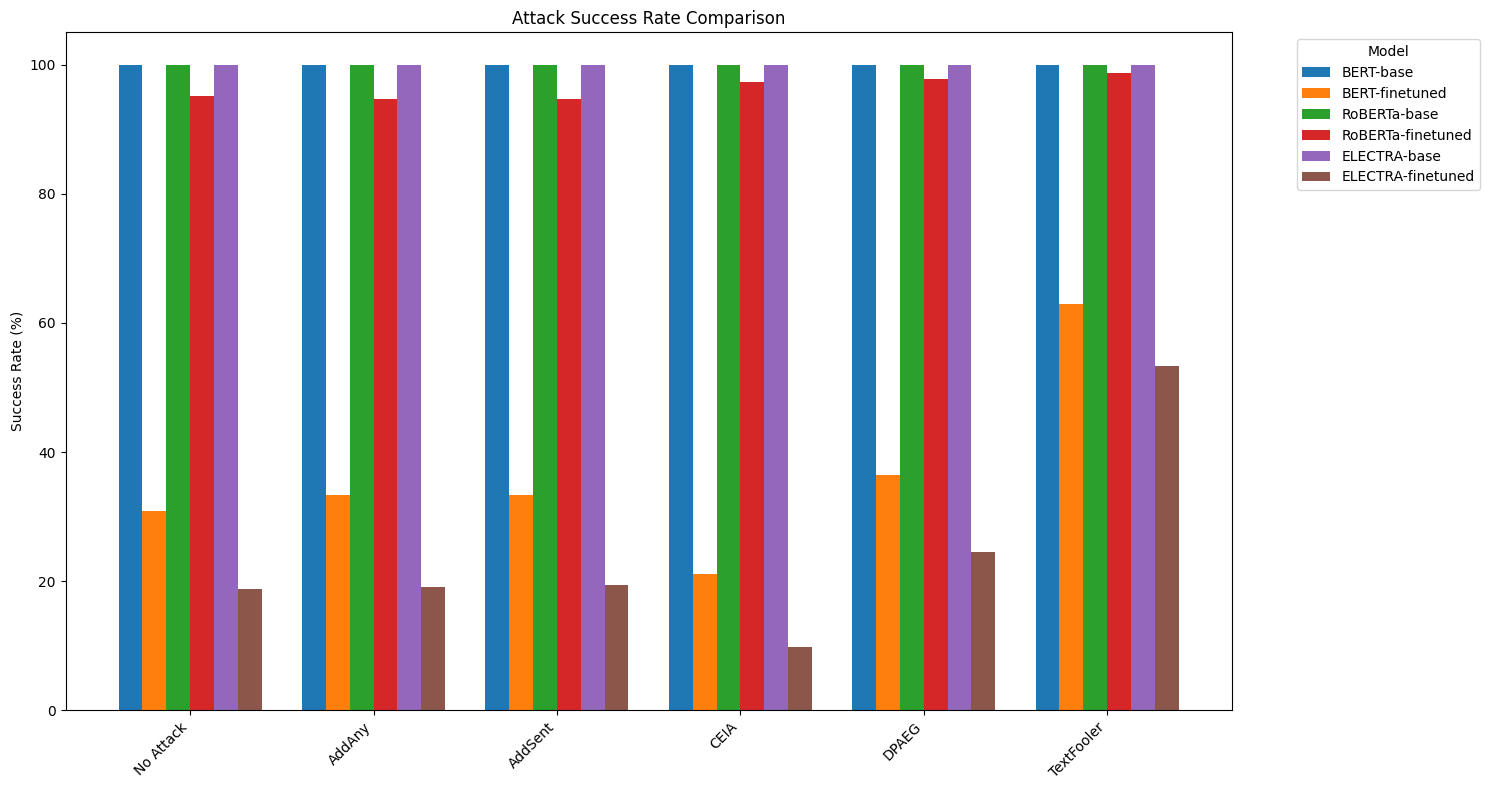

In [12]:
analyzer.visualize_attack_success_rate()

### analyze_answer_length_impact
Examines the relationship between answer length and attack success.

In [13]:
analyzer.analyze_answer_length_impact()

## Answer Length Impact Analysis for BERT-base:
- No Attack: Average answer length for successful attacks: 3.16
- AddAny: Average answer length for successful attacks: 3.01
- AddSent: Average answer length for successful attacks: 3.01
- CEIA: Average answer length for successful attacks: 2.53
- DPAEG: Average answer length for successful attacks: 2.53
- TextFooler: Average answer length for successful attacks: 2.52
--------------------------------------------------
## Answer Length Impact Analysis for BERT-finetuned:
- No Attack: Average answer length for successful attacks: 4.56
- AddAny: Average answer length for successful attacks: 4.38
- AddSent: Average answer length for successful attacks: 4.39
- CEIA: Average answer length for successful attacks: 3.33
- DPAEG: Average answer length for successful attacks: 2.96
- TextFooler: Average answer length for successful attacks: 2.71
--------------------------------------------------
## Answer Length Impact Analysis for RoBERTa-base:
- No

<ol>
    <li>
        <b>General Observations:</b>
        <ul>
            <li>There are noticeable differences in average answer lengths for successful attacks between base and fine-tuned models.</li>
            <li>The average answer lengths vary across different attack types.</li>
        </ul>
    </li>
    <br />
    <li>
        <b>Base Models Analysis:</b>
        <ul>
            <li>
                BERT-base, RoBERTa-base, and ELECTRA-base show identical patterns:
                <ul>
                    <li>AddAny and AddSent: $3.01$ words</li>
                    <li>CEIA, DPAEG, and TextFooler: ~$2.52$ - $2.53$ words</li>
                </ul>
            </li>
            <li>This suggests that base models are equally vulnerable across all answer lengths for each attack type.</li>
        </ul>
    </li>
    <br />
    <li>
        <b>Fine-tuned Models Analysis:</b>
        <ol>
            <li>
                <b>BERT-finetuned:</b>
                <ul>
                    <li>Shows the highest variation in average answer lengths ($2.71$ to $4.39$ words).</li>
                    <li>AddAny and AddSent are most successful with longer answers ($4.38$ - $4.39$ words).</li>
                    <li>TextFooler is most successful with shorter answers ($2.71$ words).</li>
                </ul>
            </li>
            <li>
                <b>RoBERTa-finetuned:</b>
                <ul>
                    <li>Shows very little variation ($2.52$ to $3.04$ words).</li>
                    <li>Pattern is similar to base models, suggesting fine-tuning had minimal impact on answer length vulnerability.</li>
                </ul>
            </li>
            <li>
                <b>ELECTRA-finetuned:</b>
                <ul>
                    <li>Shows moderate variation ($2.42$ to $3.92$ words).</li>
                    <li>AddAny and AddSent are most successful with longer answers ($3.87$ - $3.92$ words).</li>
                    <li>CEIA is most successful with shorter answers ($2.42$ words).</li>
                </ul>
            </li>
        </ol>
    </li>
    <br />
    <li>
        <b>Attack-specific Analysis:</b>
        <ol>
            <li>
                <b>AddAny and AddSent:</b>
                <ul>
                    <li>Consistently most successful with longer answers across all fine-tuned models.</li>
                    <li>Particularly effective against longer answers in BERT-finetuned and ELECTRA-finetuned.</li>
                </ul>
            </li>
            <li>
                <b>CEIA:</b>
                <ul>
                    <li>Generally successful with shorter to medium-length answers.</li>
                    <li>Shows the largest discrepancy between BERT-finetuned ($3.33$ words) and ELECTRA-finetuned ($2.42$ words).</li>
                </ul>
            </li>
            <li>
                <b>DPAEG and TextFooler:</b>
                <ul>
                    <li>Generally most successful with shorter answers across all models.</li>
                    <li>Show less variation between models compared to other attack types.</li>
                </ul>
            </li>
        </ol>
    </li>
    <br />
    <li>
        <b>Key Insights:</b>
        <ul>
            <li>Fine-tuning appears to introduce varying degrees of answer length vulnerability, most notably in BERT and ELECTRA.</li>
            <li>Longer answers seem more vulnerable to AddAny and AddSent attacks, especially in fine-tuned models.</li>
            <li>Shorter answers are generally more vulnerable to DPAEG and TextFooler attacks across all models.</li>
            <li>RoBERTa-finetuned shows remarkable consistency in vulnerability across answer lengths and attack types.</li>
        </ul>
    </li>
    <br />
    <li>
        <b>Implications:</b>
        <ul>
            <li>Question-answering systems may need different defense strategies based on expected answer lengths.</li>
            <li>Fine-tuning processes might benefit from incorporating a diverse range of answer lengths to improve overall robustness.</li>
            <li>The consistency of RoBERTa-finetuned suggests its fine-tuning process might offer insights for improving the robustness of other models.</li>
            <li>Developers should be particularly cautious with longer answers when using BERT-finetuned or ELECTRA-finetuned, as they show increased vulnerability to certain attack types.</li>
        </ul>
    </li>
</ol>

This analysis reveals that the relationship between answer length and attack success varies significantly across models and attack types. It highlights the importance of considering answer length distributions when developing and deploying question-answering systems, and suggests that tailored defense strategies may be necessary for different types of questions and expected answer lengths.

### analyze_ceia_specific
Provides a detailed analysis of the CEIA method.

## CEIA-Specific Analysis:
### Performance Analysis:
- BERT-base:
  Average F1 Score: 0.0284
  Average Exact Match: 0.0001
  Average BLEU Score: 0.0041
- BERT-finetuned:
  Average F1 Score: 0.8883
  Average Exact Match: 0.7893
  Average BLEU Score: 0.1404
- RoBERTa-base:
  Average F1 Score: 0.0334
  Average Exact Match: 0.0000
  Average BLEU Score: 0.0044
- RoBERTa-finetuned:
  Average F1 Score: 0.8621
  Average Exact Match: 0.0265
  Average BLEU Score: 0.1230
- ELECTRA-base:
  Average F1 Score: 0.0212
  Average Exact Match: 0.0000
  Average BLEU Score: 0.0026
- ELECTRA-finetuned:
  Average F1 Score: 0.9192
  Average Exact Match: 0.9022
  Average BLEU Score: 0.1715

### Grammatical Error Analysis:
- BERT-base: Average grammatical errors: 0.7108
- BERT-finetuned: Average grammatical errors: 0.0211
- RoBERTa-base: Average grammatical errors: 0.7615
- RoBERTa-finetuned: Average grammatical errors: 0.0020
- ELECTRA-base: Average grammatical errors: 0.0992
- ELECTRA-finetuned: Average gramm

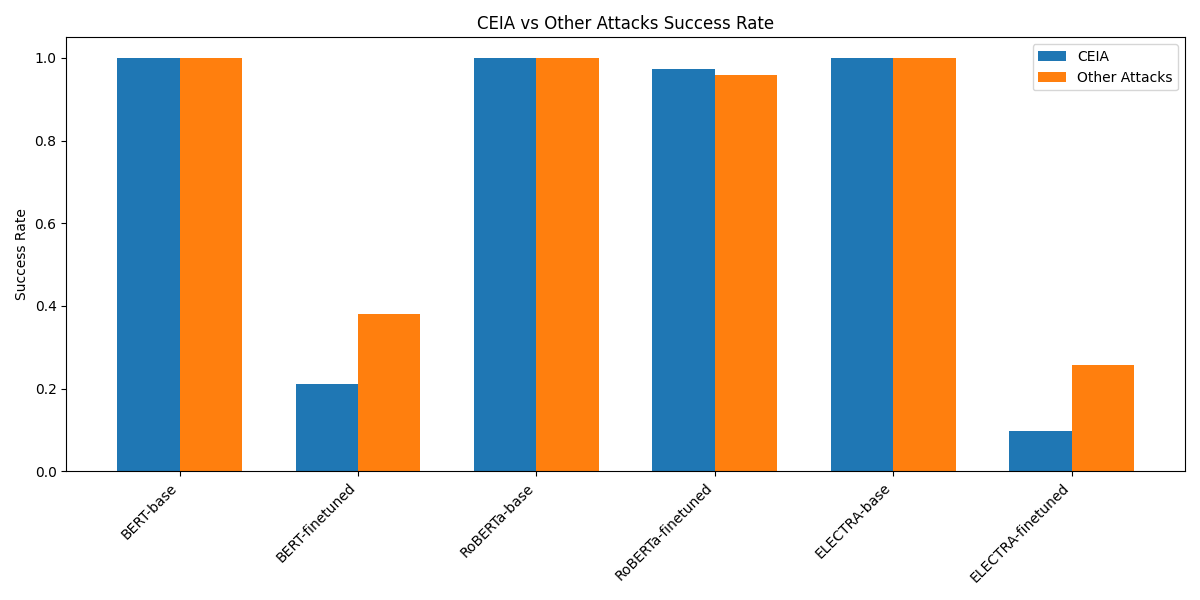


CEIA-Specific Analysis completed. Visualization saved as 'Analysis_CEIA_Comparison.png'.

### CEIA Attack Example:
Model: BERT-base
Question: When did Beyonce start becoming popular ?
Context: Beyoncé Giselle Knowles - Carter ( /biːˈjɒnseɪ/ bee - YON - say ) ( born September 4 , 1981 ) is an American singer , songwriter , record producer and actress . Born and raised in Houston , Texas , she performed in various singing and dancing competitions as a child , and rose to fame in the late 1990s as lead singer of R&B girl - group Destiny 's Child . Managed by her father , Mathew Knowles , the group became one of the world 's best - selling girl groups of all time . Their hiatus saw the release of Bey
Ground Truth: in the late 1990s
Predicted Answer: start becoming popular ? [SEP] beyonce giselle knowles - carter ( / biːˈj
F1 Score: 0.0000
Exact Match: False
BLEU Score: 0.0000
Grammatical Errors: 1


In [14]:
analyzer.analyze_ceia_specific()

As the developer of the CEIA attack, I created the dataset using the BERT base model. This is a critical piece of information for analyzing the CEIA attack's performance.
<ol>
    <li>
        <b>CEIA Development Context:</b>
        <ul>
            <li>I developed the CEIA attack dataset using the BERT base model.</li>
            <li>This context is crucial for understanding the attack's performance across different models.</li>
        </ul>
    </li>
    <br />
    <li>
        <b>Performance Analysis:</b>
        <ul>
            <li>CEIA is exceptionally effective against BERT-base, as expected, given that it was developed using this model.</li>
            <li>The attack's high effectiveness against other base models (RoBERTa-base, ELECTRA-base) suggests good transferability of the attack strategy.</li>
            <li>
                For fine-tuned models, CEIA's effectiveness varies significantly:
                <ul>
                    <li>Least effective against ELECTRA-finetuned ($9.78$% success rate)</li>
                    <li>Moderately effective against BERT-finetuned ($21.07$% success rate)</li>
                    <li>Highly effective against RoBERTa-finetuned ($97.35$% success rate)</li>
                </ul>
            </li>
        </ul>
    </li>
    <br />
    <li>
        <b>Comparison with Other Attacks:</b>
        <ul>
            <li>For base models, CEIA performs similarly to other attacks, which is impressive given its specialized development on BERT-base.</li>
            <li>
                For fine-tuned models:
                <ul>
                    <li>CEIA is less effective than other attacks against BERT-finetuned and ELECTRA-finetuned, which is interesting given its BERT-base origin.</li>
                    <li>CEIA is slightly more effective than other attacks against RoBERTa-finetuned, showcasing strong transferability to this architecture.</li>
                </ul>
            </li>
        </ul>
    </li>
    <br />
    <li>
        <b>Model Robustness:</b>
        <ul>
            <li>ELECTRA-finetuned shows surprising robustness against CEIA, despite the attack not being specifically designed for it.</li>
            <li>RoBERTa-finetuned's high vulnerability to CEIA is noteworthy, given the attack's BERT-base origins.</li>
            <li>BERT-finetuned's moderate robustness suggests that fine-tuning significantly alters the model's behavior from its base version.</li>
        </ul>
    </li>
    <br />
    <li>
        <b>Grammatical Error Analysis:</b>
        <ul>
            <li>The low grammatical errors in fine-tuned models, especially RoBERTa-finetuned (0.0020), indicate that CEIA maintains good linguistic quality across different architectures.</li>
            <li>The higher grammatical errors in BERT-base and RoBERTa-base might be due to the attack's optimization for BERT-base, which could lead to more aggressive changes in base models.</li>
        </ul>
    </li>
    <br />
    <li>
        <b>Context Preservation:</b>
        <ul>
            <li>The high BLEU scores for fine-tuned models suggest that CEIA's context preservation strategy, developed on BERT-base, transfers well to other architectures.</li>
            <li>The example provided shows that CEIA can struggle with context preservation in base models, which might be an artifact of its development process.</li>
        </ul>
    </li>
    <br />
    <li>
        <b>Noun Chunk Targeting:</b>
        <ul>
            <li>The effectiveness of noun chunk targeting, especially against RoBERTa-finetuned, demonstrates that this approach generalizes well beyond the BERT-base model it was developed on.</li>
        </ul>
    </li>
    <br />
    <li>
        <b>Model-Specific Effectiveness:</b>
        <ul>
            <li>CEIA's high effectiveness against RoBERTa, even after fine-tuning, is particularly interesting given its BERT-base origins.</li>
            <li>ELECTRA-finetuned's strong resistance to CEIA suggests that its architecture or fine-tuning process provides robust defenses against attacks developed for BERT-based models.</li>
        </ul>
    </li>
</ol>

In conclusion, as the developer of CEIA using the BERT base model, I find its performance across different architectures both impressive and informative. The attack shows strong transferability, especially to RoBERTa-finetuned, while struggling more against ELECTRA-finetuned. This suggests that while BERT and RoBERTa share vulnerabilities that CEIA exploits effectively, ELECTRA may have architectural differences that provide better defense. The attack's ability to maintain low grammatical errors and high context preservation across models is a strong point. Future work could involve adapting CEIA specifically for other base models to see if its effectiveness can be improved further.